In [1]:
%matplotlib inline
import os
import re
import collections
import textblob
import nltk
import numpy
import pandas
import tqdm

# Approach 1: Use an off-the-shelf tagger

For this we're going to use the `TextBlob` library, as we did in [The Grammar of Truth and Lies](https://youtu.be/OyA59kIQcAU)

In [2]:
text = """Peter Bleackley is a self-employed data scientist and computational linguist. He has undertaken 
Research and Development projects for clients ranging from startups to multinationals. He will shortly be 
starting a webinar series entitled "Ask a Data Scientist". """

blob = textblob.blob.TextBlob(text)

[sentence.pos_tags for sentence in blob.sentences]

[[('Peter', 'NNP'),
  ('Bleackley', 'NNP'),
  ('is', 'VBZ'),
  ('a', 'DT'),
  ('self-employed', 'JJ'),
  ('data', 'NNS'),
  ('scientist', 'NN'),
  ('and', 'CC'),
  ('computational', 'JJ'),
  ('linguist', 'NN')],
 [('He', 'PRP'),
  ('has', 'VBZ'),
  ('undertaken', 'VBN'),
  ('Research', 'NNP'),
  ('and', 'CC'),
  ('Development', 'NNP'),
  ('projects', 'NNS'),
  ('for', 'IN'),
  ('clients', 'NNS'),
  ('ranging', 'VBG'),
  ('from', 'IN'),
  ('startups', 'NNS'),
  ('to', 'TO'),
  ('multinationals', 'NNS')],
 [('He', 'PRP'),
  ('will', 'MD'),
  ('shortly', 'RB'),
  ('be', 'VB'),
  ('starting', 'VBG'),
  ('a', 'DT'),
  ('webinar', 'JJ'),
  ('series', 'NN'),
  ('entitled', 'VBN'),
  ('Ask', 'VB'),
  ('a', 'DT'),
  ('Data', 'NNP'),
  ('Scientist', 'NN')]]

# Approach 2: Custom trained Average Perceptron Tagger

The default tagger in NLTK is an [Average Perceptron Tagger](https://explosion.ai/blog/part-of-speech-pos-tagger-in-python) trained on the Penn Treebank. However, suppose we want to train our model for a different set of tags, such as WordNet word classes. We can do this by using a training corpus derived from Semcor.

In [3]:
class WordNetTaggedCorpus(object):
    def __init__(self):
        self.fileids = []
        path = nltk.find('corpora/semcor')
        for directory in ('brown1','brown2'):
            self.fileids.extend(['/'.join((directory,'tagfiles',filename))
            for filename in os.listdir('{0}/{1}/tagfiles'.format(path,directory))])
        
    def __iter__(self):
        for sentence in tqdm.tqdm(nltk.corpus.semcor.tagged_sents(self.fileids,tag='sem')):
            tagged_words = []
            for tree in sentence:
                if hasattr(tree,'label'):
                    if hasattr(tree[0],'label'):
                        pos = 'NE' if tree[0].label()=='NE' else tree[0].label().synset().pos()
                        tagged_words.extend([(word,pos)
                                            for word in tree[0]])
                    else:
                        label=tree.label()
                        pos = label.synset().pos() if hasattr(label,'synset') else label.split('.')[-2] if '.' in label else label
                        tagged_words.extend([(word,pos)
                                            for word in tree])
                else:
                    tagged_words.extend([(word,'X') for word in tree])
            yield tagged_words
                            
                                
semcor = WordNetTaggedCorpus()
                            
                                
semcor = WordNetTaggedCorpus()
tagger = nltk.tag.perceptron.PerceptronTagger(load=False)
tagger.train(semcor)
[tagger.tag(sentence.tokens) for sentence in blob.sentences]

100%|██████████| 20138/20138 [00:36<00:00, 547.57it/s]


[[('Peter', 'NE'),
  ('Bleackley', 'NE'),
  ('is', 'v'),
  ('a', 'X'),
  ('self-employed', 's'),
  ('data', 'n'),
  ('scientist', 'n'),
  ('and', 'X'),
  ('computational', 'a'),
  ('linguist', 'n'),
  ('.', 'X')],
 [('He', 'X'),
  ('has', 'X'),
  ('undertaken', 'v'),
  ('Research', 'NE'),
  ('and', 'X'),
  ('Development', 'NE'),
  ('projects', 'n'),
  ('for', 'X'),
  ('clients', 'n'),
  ('ranging', 'v'),
  ('from', 'X'),
  ('startups', 'n'),
  ('to', 'X'),
  ('multinationals', 'n'),
  ('.', 'X')],
 [('He', 'X'),
  ('will', 'X'),
  ('shortly', 'r'),
  ('be', 'X'),
  ('starting', 'v'),
  ('a', 'X'),
  ('webinar', 'n'),
  ('series', 'n'),
  ('entitled', 'v'),
  ('``', 'X'),
  ('Ask', 'v'),
  ('a', 'X'),
  ('Data', 'NE'),
  ('Scientist', 'NE'),
  ("''", 'X'),
  ('.', 'X')]]

# Approach 3: Hidden Markov Models

For some applications, we may want a probability distribution over the parts of speech, rather than a hard decision. For this, Hidden Markov Models are suitable

100%|██████████| 20138/20138 [01:55<00:00, 173.83it/s]


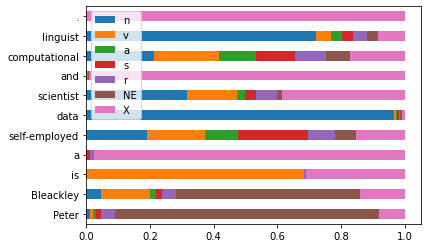

In [4]:
class HMMTagger(object):
    
    def __init__(self,corpus):
        states = ['n','v','a','s','r','NE','X']
        n=len(states)
        self.initial_state=pandas.Series(numpy.ones(n),
                                         index=states)
        self.transition_matrix=pandas.DataFrame(numpy.ones((n,n)),
                                                index=states,
                                                columns=states)
        conditional_probs={state:collections.defaultdict(lambda:1.0)
                          for state in states}
        for sentence in corpus:
            prev=None
            for (word,pos) in sentence:

                if prev is None:
                    self.initial_state[pos]+=1.0
                else:
                    self.transition_matrix.loc[pos,prev]+=1.0
                conditional_probs[pos][word]+=1.0
                prev=pos
        self.initial_state/=self.initial_state.sum()
        self.transition_matrix=self.transition_matrix.div(self.transition_matrix.sum(axis=0),
                                                          axis='columns')
        for state in states:
            conditional_probs[state]['OOV']
        pOH=pandas.DataFrame(conditional_probs).fillna(1.0)
        self.pOH=pOH.div(pOH.sum(axis=0),
                         axis='columns')
        
    def __call__(self,sentence):
        result=[]
        current = self.initial_state.copy()
        for word in sentence:
            current*=self.pOH.loc[word if word in self.pOH.index else 'OOV']
            current/=current.sum()
            result.append(current)
            current=self.transition_matrix.dot(current)
        return pandas.DataFrame(result,
                               index=sentence)
    
hmm = HMMTagger(semcor)
prob_tags = [hmm(sentence.tokens)
             for sentence in blob.sentences]
prob_tags[0].plot.barh(stacked=True)

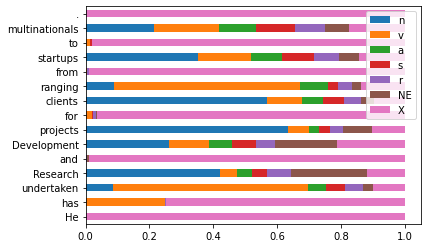

In [5]:
prob_tags[1].plot.barh(stacked=True)

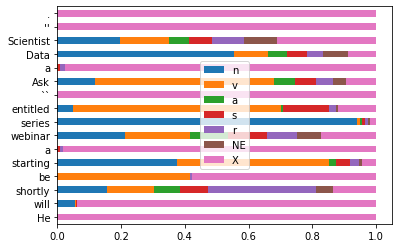

In [6]:
prob_tags[2].plot.barh(stacked=True)